# WASP-127b: Fitting RVs

In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN3
import matplotlib.pyplot as plt
import pandas as pd
CONAN3.__version__

'3.1.4'

In [2]:
from CONAN3.get_files import get_parameters

sys_params = get_parameters(planet_name="WASP-127b")  #result cached in the current working directory
sys_params

Loading parameters from cache ...


{'star': {'Teff': (5620.0, 85.0),
  'logg': (4.18, 0.01),
  'FeH': (-0.193, 0.014),
  'radius': (1.33, 0.03),
  'mass': (0.95, 0.02),
  'density': (0.565, 0.035)},
 'planet': {'period': (4.17806203, 8.8e-07),
  'rprs': (0.10103, 0.00026),
  'mass': (0.1647, 0.0214),
  'ecc': (0.0, nan),
  'w': (nan, nan),
  'T0': (2456776.62124, 0.00023),
  'b': (0.29, 0.04),
  'T14': (4.35288, 0.0084),
  'aR': (7.81, 0.11),
  'K[m/s]': (22.0, 3.0)}}

Even though we are not fitting lightcurves, we need to instantiate the lightcurve obj `lc_obj` since the planet parameters are created there, so we link it to the `rv_obj`

In [3]:
lc_obj = CONAN3.load_lightcurves()
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name filt 𝜆_𝜇m |s_samp  clip    scl_col |col0 col3 col4 col5 col6 col7 col8|sin id GP spline_config  


In [39]:
t0  = sys_params["planet"]["T0"][0] - 2450000

planet_pars = dict( T_0           = t0,                                    #fixed
                    Period        = sys_params["planet"]["period"][0],     #fixed
                    rho_star      = sys_params["star"]["density"][0],      #fixed
                    Impact_para   = 0,  
                    RpRs          = 0.108,                  
                    Eccentricity  = 0,
                    omega         = 90,
                    K             = 0)

## Setup RV

The RV setup is similar to the LC

In [40]:
path ="../data/"
rv_list = ["rv1.dat","rv2.dat"]    #rv data in km/s

In [41]:
rv_obj = CONAN3.load_rvs(file_list     = rv_list, 
                         data_filepath = path,
                         rv_unit       ='km/s',
                         nplanet       = 1,
                         lc_obj        = lc_obj      #load lc_obj to update planet parameters
                        )
rv_obj

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        
rv2.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        


rvs from filepath: ../data/
1 planet(s)

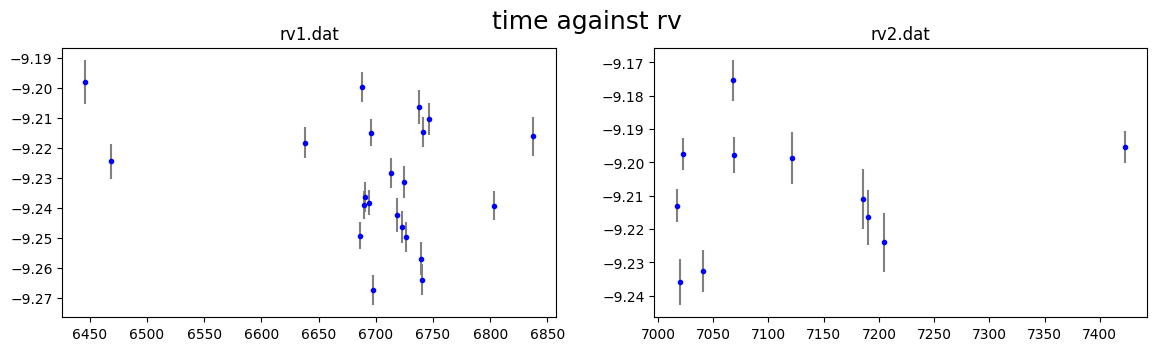

In [42]:
rv_obj.plot()

In [43]:
rv_obj.rescale_data_columns()

Rescaled data columns of rv1.dat with method:med_sub
Rescaled data columns of rv2.dat with method:med_sub


We can update the relevant RV parameters since they were not defined in `lc_obj` 

e.g. add a prior for the RV semi-amplitude `K`

In [27]:
lc_obj.planet_parameters(**planet_pars)

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name        	fit	prior
rho_star    	n  	F(0.565)
------------
RpRs        	n  	F(0.108)
Impact_para 	n  	F(0.29)
T_0         	n  	F(6776.621239999775)
Period      	n  	F(4.17806203)
Eccentricity	n  	F(0)
omega       	n  	F(90)
K           	n  	F(0)


In [28]:
t0  = sys_params["planet"]["T0"][0] - 2450000

rv_obj.update_planet_parameters(T_0    = t0,
                                Period = sys_params["planet"]["period"][0],
                                K      = (0,10e-3,50e-3))   

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name        	fit	prior
rho_star    	n  	F(0.565)
------------
RpRs        	n  	F(0.108)
Impact_para 	n  	F(0.29)
T_0         	n  	F(6776.621239999775)
Period      	n  	F(4.17806203)
Eccentricity	n  	F(0)
omega       	n  	F(90)
K           	y  	U(0,0.01,0.05)


### Baseline and decorrelation

- similar to lightcurves, we can manually specify the rv baseline model using the `.rv_baseline()` method

In [29]:
rv_obj.rv_baseline( dcol0 = None,
                    dcol3 = None,
                    dcol4 = None,
                    dcol5 = None,
                    gamma = [(-9.232,0.1), (-9.21,0.1)],
                    gp    = "n")

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.232,0.1) 
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.21,0.1)  


- or we can use the `.get_decorr()` method to find the best decorrelation 

In [31]:
rvdecorr_res= rv_obj.get_decorr(T_0     = planet_pars["T_0"],
                                Period  = planet_pars["Period"],
                                K       = (0,22e-3,100e-3),       #km/s
                                gamma   = (-9.21,0.1),
                                delta_BIC = -5)


getting decorrelation parameters for rv: rv1.dat (jitt=0.00km/s)

BEST BIC:85.63, pars:['B0']

getting decorrelation parameters for rv: rv2.dat (jitt=0.00km/s)

BEST BIC:14.02, pars:[]
Setting-up rv baseline model from result
# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   2    0    0    0|   0 n  None            | N(-9.233510019208504,0.1)
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.21055483295252,0.1)


## Setup Sampling

finally to setup the `fit_obj` which is used to configure the fitting.

We can specify values for the stellar mass or radius to be used to convert parameter results to physical values. These values are not used in the fit, only for the post-fit conversion. We can also take the values from our NASA archive `sys_params` dictionary

In [32]:
sys_params["star"]["radius"], sys_params["star"]["mass"]

((1.33, 0.03), (0.95, 0.02))

In [33]:
fit_obj = CONAN3.fit_setup( M_st = sys_params["star"]["mass"],
                            par_input = "Mrho",
                            apply_LCjitter="y", apply_RVjitter="y",
                            LCbasecoeff_lims="auto", RVbasecoeff_lims="auto")

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.000,0.010)
Mass_[Msun]    N(0.950,0.020)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Mrho


setup sampling using the `.sampling()` method of `fit_obj`. Note that the sampling of the parameter space can be done with `emcee` or `dynesty`. The default is `dynesty`

In [34]:
fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=100)

# ============ FIT setup =====================================================================================
Number_steps                       2000 
Number_chains                      64 
Number_of_processes                10 
Burnin_length                      500 
n_live                             100 
force_nlive                        False 
d_logz                             0.1 
Sampler(emcee/dynesty)             dynesty 
emcee_move(stretch/demc/snooker)   stretch 
leastsq_for_basepar(y/n)           n 
apply_LCjitter(y/n)                y 
apply_RVjitter(y/n)                y 
LCjitter_loglims([lo,hi])          [-15, -4] 
RVjitter_lims([lo,hi])             [0, 5] 
LCbasecoeff_lims(auto/[lo,hi])     auto 
RVbasecoeff_lims(auto/[lo,hi])     auto 


## Export configuration

All configuration can be exported to a `config.dat` file that allows to reproduce all steps and eventually run the fit

In [35]:
CONAN3.create_configfile(lc_obj, rv_obj, fit_obj,
                         filename='wasp127_rv_config.dat')

configuration file saved as wasp127_rv_config.dat


In [36]:
#reload objects from config file

import CONAN3
lc_obj, rv_obj, fit_obj = CONAN3.load_configfile('wasp127_rv_config.dat')

lc_list is None: No lightcurve to clip outliers.


## Sampling

Finally perform the **fitting** which returns a result object `result_obj` that holds the chains of the mcmc and allows subsequent plotting.

The result of the fit is saved to a user-defined folder (default = 'output'). If a fit result already exists in this folder, it is loaded to the `result_obj`

In [37]:
result = CONAN3.run_fit(lc_obj  = lc_obj,
                        rv_obj  = rv_obj,
                        fit_obj = fit_obj,
                        out_folder="result_wasp127_rv_fit_dyn",
                        rerun_result=True);

Fit result already exists in this folder: result_wasp127_rv_fit_dyn.
Rerunning with results to generate plots and files...

CONAN fit launched!!!

Setting up photometry arrays ...
Setting up RV arrays ...
Plotting prior distributions

Plotting initial guess
---------------------------

============ Samping started ... (using dynesty)======================
No of dimensions:  7

Skipping dynesty run. Loading chains from disk

Dynesty chain written to disk as result_wasp127_rv_fit_dyn/chains_dict.pkl. Run `result=CONAN3.load_result()` to load it.

============ Sampling Finished ==============================================

saved 1 corner plot(s) as result_wasp127_rv_fit_dyn/corner_*.png

Plotting output figures
RV1 ...Writing RV output to file: result_wasp127_rv_fit_dyn/rv1_rvout.dat
RV2 ...Writing RV output to file: result_wasp127_rv_fit_dyn/rv2_rvout.dat


['lc'] Output files, [], loaded into result object
['rv'] Output files, ['rv1_rvout.dat', 'rv2_rvout.dat'], loaded into result obj

## results

In [53]:
import CONAN3
import matplotlib.pyplot as plt
from CONAN3.utils import bin_data, phase_fold

In [44]:
result =CONAN3.load_result(folder="result_wasp127_rv_fit_dyn")
result

['lc'] Output files, [], loaded into result object
['rv'] Output files, ['rv1_rvout.dat', 'rv2_rvout.dat'], loaded into result object


Object containing posterior from emcee/dynesty sampling                 
Parameters in chain are:
	 ['K', 'rv1_gamma', 'rv1_jitter', 'rv2_gamma', 'rv2_jitter', 'rv1_A0', 'rv1_B0']                 

use `plot_chains()`, `plot_burnin_chains()`, `plot_corner()` or `plot_posterior()` methods on selected parameters to visualize results.

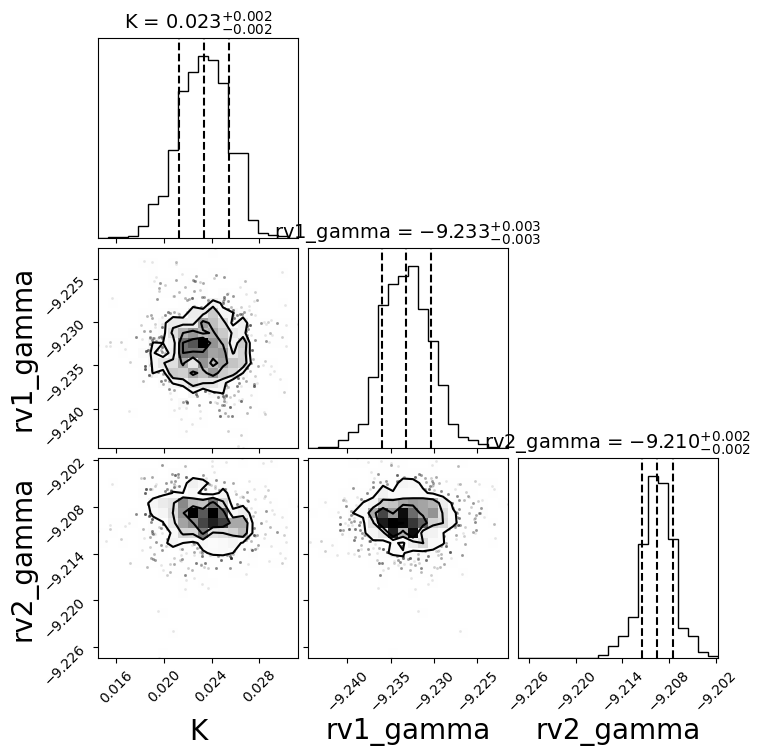

In [47]:
fig = result.plot_corner(pars =['K','rv1_gamma','rv2_gamma']);

### RVs

In [49]:
result.rv.names

['rv1.dat', 'rv2.dat']

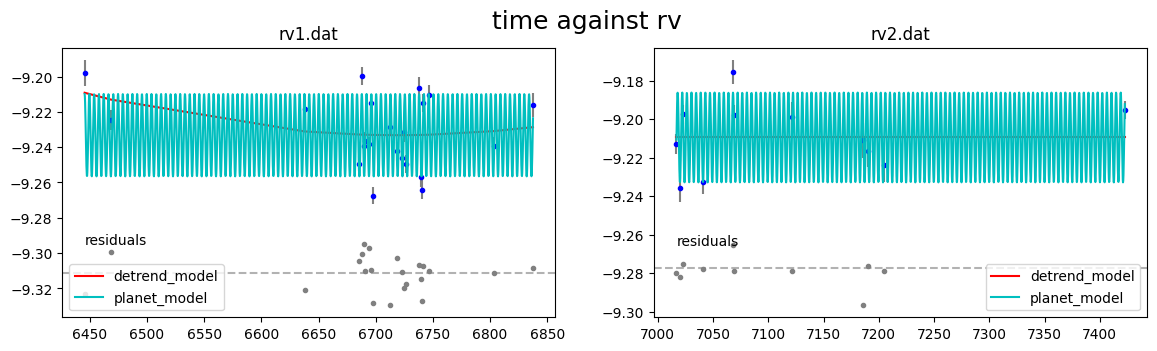

In [50]:
fig = result.rv.plot_bestfit()

In [51]:
#load output data files for the rv fits
rv1data = result.rv.outdata['rv1.dat']
rv2data = result.rv.outdata['rv2.dat']

rv1data.head()

,time,RV,error,full_mod,base,Rvmodel,det_RV,spl_fit,phase
0,6445.543512,-9.197929,0.012548,-9.185879,-9.209182,0.023304,0.011253,0.0,-0.241937
1,6468.462797,-9.224495,0.011756,-9.236359,-9.213044,-0.023316,-0.011451,0.0,0.243689
2,6637.825616,-9.218248,0.011467,-9.208177,-9.231100,0.022923,0.012852,0.0,-0.220097
3,6685.729323,-9.249265,0.011149,-9.256184,-9.232859,-0.023324,-0.016406,0.0,0.245436
4,6687.689793,-9.199722,0.011416,-9.210139,-9.232900,0.022761,0.033178,0.0,-0.285334


In [54]:
#evaluate RV model on a smoother time array
t_sm  = np.linspace(rv1data["time"].min(), rv1data["time"].max(), 1000)
rvmod = result.rv.evaluate(file="rv1.dat",time=t_sm, return_std=True)

phases = phase_fold(t=t_sm, per=result.params.P, t0=result.params.T0, phase0=-0.5)
#sort
srt    = np.argsort(phases)

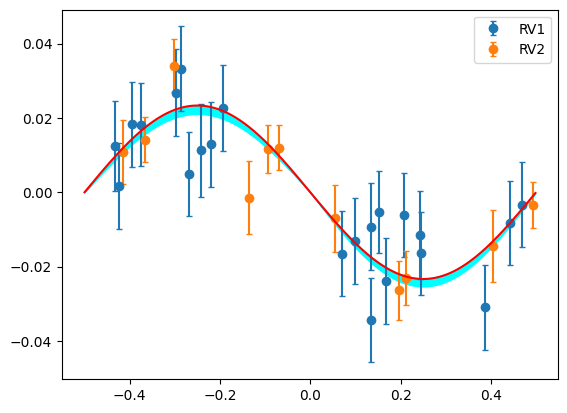

In [55]:
plt.errorbar(rv1data["phase"],rv1data["det_RV"],rv1data["error"],fmt="o",capsize=2,label="RV1")
plt.errorbar(rv2data["phase"],rv2data["det_RV"],rv2data["error"],fmt="o",capsize=2,label="RV2")

plt.plot(phases[srt], rvmod.planet_model[srt],"r",zorder=5)

plt.fill_between(phases[srt],rvmod.sigma_low[srt], rvmod.sigma_high[srt], color="cyan")


plt.legend()